In [1]:
# !pip install tensorflow
# !pip install tensorflow_datasets
# !pip install tensorflow_hub
# !pip install keras_cv
# !pip install keras-cv tensorflow --upgrade
# apt-get update && apt-get install -y python3-opencv
# !pip install opencv-python
# !pip install opencv-python opencv-python-headless
# !pip install pycocotools
# !pip install --upgrade -q git+https://github.com/keras-team/keras-cv

In [2]:
!python --version

Python 3.11.0rc1


In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import optimizers
import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization
import cv2
import numpy as np
import os
import resource
import tqdm

import my_dataset.my_dataset_dataset_builder

%load_ext tensorboard
%load_ext autoreload
%autoreload 2

2023-10-31 17:15:26.784921: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-31 17:15:26.821194: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-31 17:15:26.821225: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-31 17:15:26.821246: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-31 17:15:26.828097: I tensorflow/core/platform/cpu_feature_g

Using TensorFlow backend


In [7]:
BATCH_SIZE = 4

class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


def unpackage_raw_tfds_inputs(inputs, bounding_box_format):
    image = inputs["image"]
    boxes = keras_cv.bounding_box.convert_format(
        inputs["objects"]["bbox"],
        images=image,
        source="rel_yxyx",
        target=bounding_box_format,
    )
    bounding_boxes = {
        "classes": tf.cast(inputs["objects"]["label"], dtype=tf.float32),
        "boxes": tf.cast(boxes, dtype=tf.float32),
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


def load_pascal_voc(split, dataset, bounding_box_format):
    ds = tfds.load(dataset, split=split, with_info=False, shuffle_files=True)
    ds = ds.map(
        lambda x: unpackage_raw_tfds_inputs(x, bounding_box_format=bounding_box_format),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    return ds


train_ds = load_pascal_voc(
    split="train", dataset="voc/2007", bounding_box_format="xywh"
)
eval_ds = load_pascal_voc(split="test", dataset="voc/2007", bounding_box_format="xywh")

train_ds = train_ds.shuffle(BATCH_SIZE * 4)

In [8]:
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
eval_ds = eval_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

In [11]:
next(iter(train_ds))

{'images': <tf.RaggedTensor [[[[17.0, 11.0, 13.0],
    [31.0, 27.0, 28.0],
    [27.0, 28.0, 30.0],
    ...,
    [113.0, 95.0, 73.0],
    [106.0, 90.0, 67.0],
    [105.0, 89.0, 66.0]], [[27.0, 21.0, 23.0],
                           [22.0, 18.0, 19.0],
                           [20.0, 20.0, 20.0],
                           ...,
                           [112.0, 94.0, 72.0],
                           [109.0, 91.0, 69.0],
                           [107.0, 91.0, 68.0]], [[36.0, 30.0, 30.0],
                                                  [24.0, 20.0, 19.0],
                                                  [32.0, 32.0, 30.0],
                                                  ...,
                                                  [111.0, 93.0, 71.0],
                                                  [110.0, 92.0, 70.0],
                                                  [111.0, 93.0, 71.0]],
   [[31.0, 26.0, 23.0],
    [25.0, 21.0, 18.0],
    [43.0, 42.0, 40.0],
    ...,
    [111.0, 9

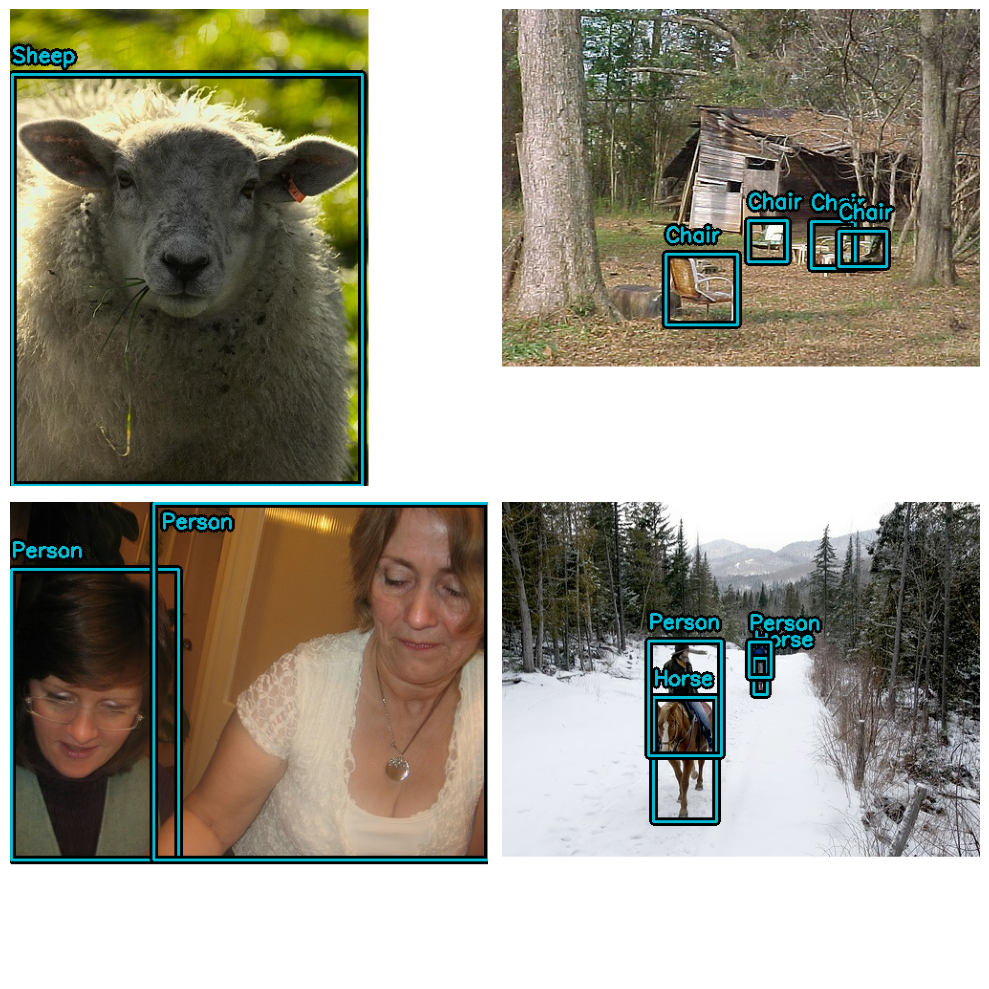

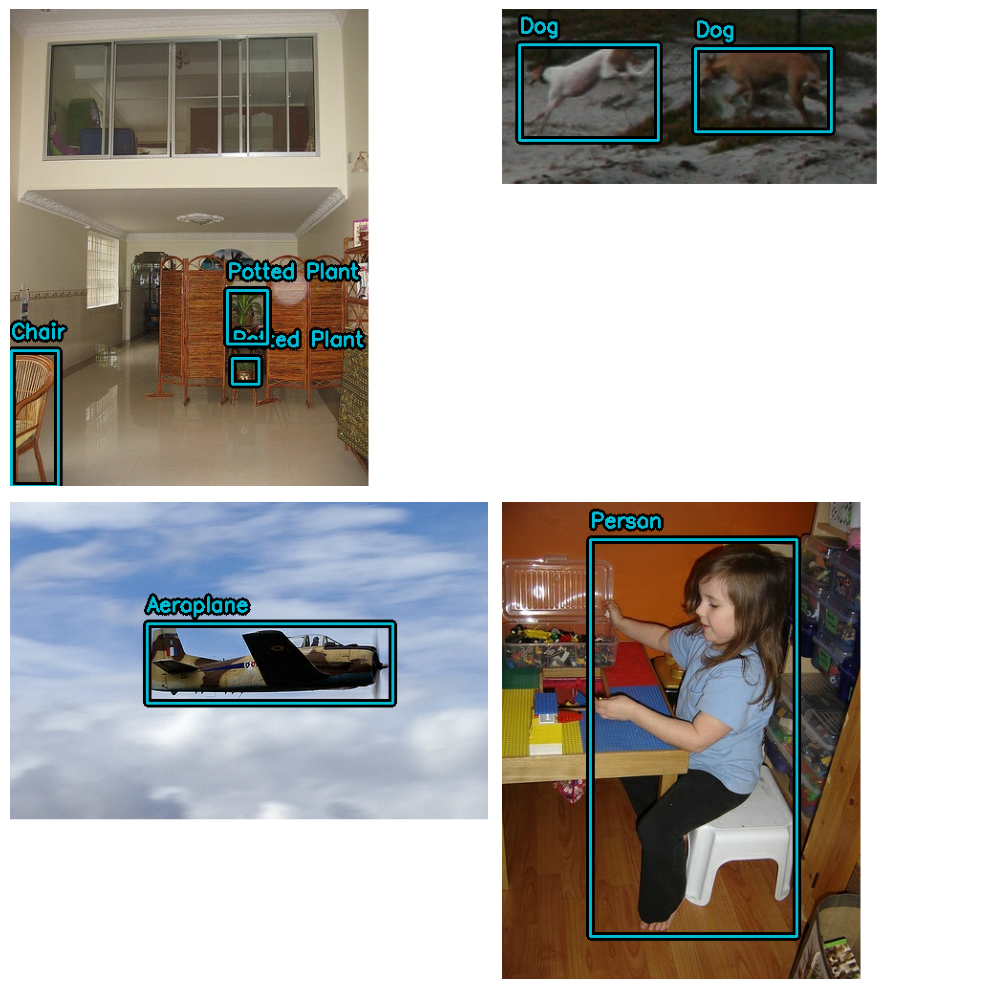

In [9]:
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    eval_ds,
    bounding_box_format="xywh",
    value_range=(0, 255),
    rows=2,
    cols=2,
    # If you are not running your experiment on a local machine, you can also
    # make `visualize_dataset()` dump the plot to a file using `path`:
    # path="eval.png"
)

In [ ]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xywh"
        ),
    ]
)

train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

In [ ]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format="xywh", pad_to_aspect_ratio=True
)
eval_ds = eval_ds.map(inference_resizing, num_parallel_calls=tf.data.AUTOTUNE)

visualize_dataset(
    eval_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

In [ ]:
def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = eval_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
eval_ds = eval_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
base_lr = 0.005
# including a global_clipnorm is extremely important in object detection tasks
optimizer = tf.keras.optimizers.SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)

In [ ]:
pretrained_model = keras_cv.models.RetinaNet.from_preset(
    "retinanet_resnet50_pascalvoc", bounding_box_format="xywh"
)

pretrained_model.compile(
    classification_loss="focal",
    box_loss="smoothl1",
)

In [ ]:
def print_metrics(metrics):
    maxlen = max([len(key) for key in result.keys()])
    print("Metrics:")
    print("-" * (maxlen + 1))
    for k, v in metrics.items():
        print(f"{k.ljust(maxlen+1)}: {v.numpy():0.2f}")

coco_metrics = keras_cv.metrics.BoxCOCOMetrics(
    bounding_box_format="xywh", evaluate_freq=20
)

In [ ]:
pretrained_model.compile(
    classification_loss="focal",
    box_loss="smoothl1",
    optimizer=optimizer,
    metrics=[coco_metrics],
)
coco_metrics.reset_state()
result = pretrained_model.evaluate(val_ds.take(1), verbose=0)
result = coco_metrics.result(force=True)

print_metrics(result)

In [ ]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xywh",
            # passing 1e9 ensures we never evaluate until
            # `metrics.result(force=True)` is
            # called.
            evaluate_freq=1e9,
        )

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in tqdm.tqdm(self.data):
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)
        return logs

In [ ]:
model = keras_cv.models.RetinaNet.from_preset(
    "resnet50_imagenet",
    num_classes=len(class_mapping),
    # For more info on supported bounding box formats, visit
    # https://keras.io/api/keras_cv/bounding_box/
    bounding_box_format="xywh",
)

In [ ]:
model.compile(
    classification_loss="focal",
    box_loss="smoothl1",
    optimizer=optimizer,
    # We will use our custom callback to evaluate COCO metrics
    metrics=None,
)

In [ ]:
model.fit(
    train_ds.take(20),
    validation_data=val_ds.take(20),
    # Run for 10-35~ epochs to achieve good scores.
    epochs=1,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds.take(20))],
)

In [ ]:
model = keras_cv.models.RetinaNet.from_preset(
    "retinanet_resnet50_pascalvoc", bounding_box_format="xywh"
)

In [ ]:
visualization_ds = val_ds.unbatch()
visualization_ds = visualization_ds.ragged_batch(16)
visualization_ds = visualization_ds.shuffle(8)

In [ ]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=4,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

In [ ]:
model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.75,
)

visualize_detections(model, dataset=visualization_ds, bounding_box_format="xywh")

In [ ]:
class VisualizeDetections(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        visualize_detections(
            self.model, bounding_box_format="xywh", dataset=visualization_dataset
        )